In [3]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import linregress
import statsmodels.api as sm
from scipy.optimize import minimize
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
%pip install tabulate
%pip install causalinference
from causalinference import CausalModel
from tabulate import tabulate
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [428]:
#Importing Raw Company data
with open('GVC TFP Data.txt', 'r') as file:
    data = file.read()
df = pd.read_csv('GVC TFP Data.txt', delimiter = '|')
print(f"Number of columns in DataFrame: {len(df.columns)}")

#Importing Industry Codes
industry_codes_df = pd.read_excel('Industry Codes.xlsx')
print(industry_codes_df.head())
#print(df.head())


Number of columns in DataFrame: 207
   NIC Industry Code                NIC Industry Name          2006          2007          2008           2009           2010           2011          2012           2013           2014           2015
0                 10     Manufacture of Food Products  60455.973487  64998.591122  74262.412921   79001.235050   90769.944688  105744.561968  29251.129876  143626.125675  163185.904569  174343.278068
1                 11         Manufacture of Beverages  60455.973487  64998.591122  74262.412921  132383.089315  138261.660289  152046.692120  31381.456720  197707.617331  236422.366205  244906.395722
2                 12  Manufacture of Tobacco Products  25428.835662  35217.784863  30214.267320   32727.099769   38000.314483   47321.432901  29209.173081   55314.899078   53666.095806   66477.849306
3                 13          Manufacture of Textiles  69245.935137  61818.360222  80315.739875   85172.549487   95180.476688  110157.506799  32418.884377  136061.2

C:\Users\giris\AppData\Local\Temp\ipykernel_35816\2329116416.py:4: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('GVC TFP Data.txt', delimiter = '|')


In [ ]:

# Read the data using the appropriate delimiter
df = pd.read_csv('GVC TFP Data.txt', delimiter='|')  

print(f"Number of columns in DataFrame: {len(df.columns)}")

# Create column names with correct years
start_year = 2006
num_years = 10  
years = [start_year + i for i in range(num_years)]  

# Base columns with short names
base_columns = {
    "Sales": "Sales",
    "Change in stock of finished goods": "Stock_FG",
    "Change in stock of wip and semifinished goods": "Stock_WIP",
    "Raw materials, stores & spares": "Raw_Mat",
    "Purchase of finished goods": "Purchase_FG",
    "Power & fuel": "Power_Fuel",
    "Salaries & wages": "Salaries_Wages",
    "Net fixed assets": "Net_FixedAssets",
    "Gross fixed assets": "Gross_FixedAssets",
    "Total assets": "Total_Assets",
    "Current assets (incl. short term investments, loans & advances)": "Current_Assets",
    "Export of goods(fob)": "Export_Goods",
    "Export of services": "Export_Services",
    "Import of raw materials (cif)": "Import_Raw_Mat",
    "Import of stores and spares (cif)": "Import_Stores_Spares",
    "Import of finished goods (cif)": "Import_FG",
    "Import of capital goods (cif)": "Import_Cap_Goods",
    "Gross fixed assets depreciation during the year": "Dep_Gross_FA",
    "Current liabilities": "Current_Liab",
    "Short-term borrowings": "Short_Term_Borrow"
}

# Columns without years
static_columns = ["Company Name", "Incorporation Year", "NIC code"]

# Columns with specific years
specific_year_columns = [
    "Indian Promoters (In %) - Shares held",
    "Foreign Promoters (In %) - Shares held"
]

columns = static_columns.copy()

# Adding specific year columns
for col in specific_year_columns:
    for year in [start_year + 9, start_year]: 
        columns.append(f"{col}_{year}")

# Adding base columns for each year
for year in years:
    for base_col in base_columns.values():
        columns.append(f"{base_col}_{year}")

df.columns = columns 


Number of columns in DataFrame: 207


C:\Users\giris\AppData\Local\Temp\ipykernel_35816\2983190949.py:4: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('GVC TFP Data.txt', delimiter='|')


In [ ]:
#Definations of functions

# Function to print vales of each variable for all years
def variable_data(df, variable):
    variable_columns = [col for col in df.columns if variable in col] 
    selected_columns = ['Company Name'] + variable_columns
    variable_data = df[selected_columns]
    return variable_data

# Function to print all columns for a specific company
def print_company_data(df, company_name):
    company_data = df[df['Company Name'] == company_name]
    print(company_data)

# Reorder columns 
def reorder_columns(df, cols_to_move, position):
    cols = df.columns.tolist()
    for col in cols_to_move:
        cols.insert(position, cols.pop(cols.index(col)))
        position += 1
    return df[cols]

# Function to drop companies with negative sales
def drop_negative_sales(df, years):
    deleted_companies = pd.DataFrame()
    
    for year in years:
        sales_col = f"Sales_{year}"
        negative_sales = df[df[sales_col] < 0]
        deleted_companies = pd.concat([deleted_companies, negative_sales])
        df = df[df[sales_col] >= 0]
    # Remove duplicates from deleted_companies
    deleted_companies = deleted_companies.drop_duplicates()
    return df, deleted_companies

#Converting columns to numeric
columns_to_convert = [col for col in df.columns if col != 'Company Name' and any(str(year) in col for year in range(2005, 2016))]
#Print the columns to convert
print("Columns to convert:", columns_to_convert)
for col in columns_to_convert:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')


Columns to convert: ['Indian Promoters (In %) - Shares held_2015', 'Indian Promoters (In %) - Shares held_2006', 'Foreign Promoters (In %) - Shares held_2015', 'Foreign Promoters (In %) - Shares held_2006', 'Sales_2006', 'Stock_FG_2006', 'Stock_WIP_2006', 'Raw_Mat_2006', 'Purchase_FG_2006', 'Power_Fuel_2006', 'Salaries_Wages_2006', 'Net_FixedAssets_2006', 'Gross_FixedAssets_2006', 'Total_Assets_2006', 'Current_Assets_2006', 'Export_Goods_2006', 'Export_Services_2006', 'Import_Raw_Mat_2006', 'Import_Stores_Spares_2006', 'Import_FG_2006', 'Import_Cap_Goods_2006', 'Dep_Gross_FA_2006', 'Current_Liab_2006', 'Short_Term_Borrow_2006', 'Sales_2007', 'Stock_FG_2007', 'Stock_WIP_2007', 'Raw_Mat_2007', 'Purchase_FG_2007', 'Power_Fuel_2007', 'Salaries_Wages_2007', 'Net_FixedAssets_2007', 'Gross_FixedAssets_2007', 'Total_Assets_2007', 'Current_Assets_2007', 'Export_Goods_2007', 'Export_Services_2007', 'Import_Raw_Mat_2007', 'Import_Stores_Spares_2007', 'Import_FG_2007', 'Import_Cap_Goods_2007', 'De

In [431]:
##Merging the data
# Ensure the NIC Code column in df contains the first two digits
df["NIC Industry Code"] = df["NIC code"].astype(str).str[:2]

# Ensure the NIC Industry Code in industry_codes_df is a string
industry_codes_df["NIC Industry Code"] = industry_codes_df["NIC Industry Code"].astype(str)

# Rename the columns in industry_codes_df to avoid conflicts
industry_codes_df = industry_codes_df.rename(columns={"NIC Industry Name": "Industry_Name", "NIC Industry Code": "NIC_Industry_Code"})

# Merge the company DataFrame with the industry codes DataFrame
df = df.merge(
    industry_codes_df[['NIC_Industry_Code', 'Industry_Name']],
    left_on="NIC Industry Code",  # Match based on the NIC Industry Code
    right_on="NIC_Industry_Code",  # Match based on the renamed NIC Industry Code
    how="left",               # Use left join to keep all rows from df
    suffixes=('', '_duplicate')  # Avoid duplicate column names
)

# Drop the redundant column if it exists
if 'Industry_Name_duplicate' in df.columns:
    df = df.drop(columns=['Industry_Name_duplicate'])
df = df.drop(columns=["NIC_Industry_Code"])

columns_to_move = ["NIC Industry Code", "Industry_Name"]
position = 3
df = reorder_columns(df, columns_to_move, position)
# Verify the column names in industry_codes_df
# print(industry_codes_df.columns)


C:\Users\giris\AppData\Local\Temp\ipykernel_35816\3374907558.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["NIC Industry Code"] = df["NIC code"].astype(str).str[:2]


In [ ]:
# Data Cleaning - 02

# Convert Sales columns to numeric, forcing errors to NaN
for year in years:
	sales_col = f"Sales_{year}"
	df[sales_col] = pd.to_numeric(df[sales_col].astype(str).str.replace(',', ''), errors='coerce')


# Number of firms in the data
num_firms = variable_data(df, 'Company Name').nunique()
print(f"Number of firms in DataFrame: {num_firms}")
# print(df.head())

## Filtering out companies with negative sales
negative_or_zero_sales = {}
negative_sales_companies = {}

for year in years:
    sales_col = f"Sales_{year}"
    negative_sales = df[df[sales_col] <= 0]
    negative_or_zero_sales[year] = negative_sales['Company Name'].nunique()
    negative_sales_companies[year] = negative_sales['Company Name'].unique()
print(f"Negative sales companies in each year:{negative_or_zero_sales}")


# Drop companies with negative sales
# Create a mask for rows with negative sales in any year
negative_sales_mask = df[[f"Sales_{year}" for year in years]].lt(0).any(axis=1)

# Filter out rows with negative sales
negative_sales_df = df[negative_sales_mask]
df = df[~negative_sales_mask]

# print(f"Companies reporting sales data in each year:\n {variable_data(df, 'Sales').count()}")
# print(f"Companies with missing sales data in each year:\n{variable_data(df, 'Sales').isna().sum()}")
# print(f"Negative sales companies in each year:{negative_or_zero_sales}")

sales_data = variable_data(df, 'Sales')

# Create a boolean mask for zero or missing sales
zero_or_missing_sales_mask = (sales_data == 0) | (sales_data.isna())

zero_or_missing_count = zero_or_missing_sales_mask.sum(axis=1)

# Identify companies with zero or missing sales for at least 3 years
companies_less_than_three_years = df[zero_or_missing_count >= 3] # df backup
# Count the number of such companies
companies_sales_less_than_three_years_count = companies_less_than_three_years['Company Name'].nunique()
print(f"Number of companies with zero or missing sales for at least 3 years: {companies_sales_less_than_three_years_count}")
# Drop companies with zero or missing sales for at least 3 years
df = df[zero_or_missing_count < 3]
#print(f"Number of firms in DataFrame: {num_firms}")

# print(variable_data(df, 'Sales'))

Number of firms in DataFrame: Company Name    18060
Company Name    18060
dtype: int64
Negative sales companies in each year:{2006: 0, 2007: 0, 2008: 1, 2009: 1, 2010: 2, 2011: 1, 2012: 0, 2013: 1, 2014: 1, 2015: 4}
Number of companies with zero or missing sales for at least 3 years: 7352
Number of firms in DataFrame: Company Name    18060
Company Name    18060
dtype: int64


In [433]:
#adding the database of accumulated depreciation
with open('Acc_Dep_Data.txt', 'r') as file:
    data = file.read()
df_1 = pd.read_csv('Acc_Dep_Data.txt', delimiter = '|')
print(f"Number of columns in DataFrame: {len(df.columns)}")
# print(df_1.head())
# Rename columns in df_1 to match the format in df
df_1.columns = ['Company Name'] + [f'Acc_Dep_{year}' for year in years]


for year in years:
    acc_dep_col = f"Acc_Dep_{year}"
    df[acc_dep_col] = df['Company Name'].map(df_1.set_index('Company Name')[acc_dep_col])


Number of columns in DataFrame: 209


In [434]:
# Calculating components of TFP (Yay! reached here woof)

# Calculating capital stocks

# Calculating the rate of accounting depreciation

# Function to calculate the rate of accounting depreciation for each firm
def calculate_dep_rate(df, years):
    depreciation_rates = []

    for year in years:
        gross_fixed_assets_col = f"Gross_FixedAssets_{year}"
        acc_dep_col = f"Acc_Dep_{year}"
        df[acc_dep_col] = pd.to_numeric(df[acc_dep_col].astype(str).str.replace(',', ''), errors='coerce')
        
        # Calculate the net block
        net_block = df[gross_fixed_assets_col] - df[acc_dep_col]
        
        # Handle division by zero or missing values
        with np.errstate(divide='ignore', invalid='ignore'):
            depreciation_rate = np.where(net_block != 0, df[acc_dep_col] / net_block, np.nan)
        
        # Append the depreciation rate to the list
        depreciation_rates.append(depreciation_rate)
    
    # Convert the list to a DataFrame
    depreciation_rates_df = pd.DataFrame(depreciation_rates).transpose()
    
    # Calculate the average depreciation rate over the specified period
    df['Average_Depreciation_Rate'] = depreciation_rates_df.mean(axis=1)
    
    return df

# Example usage
df = calculate_dep_rate(df, years)
## I have not used the depreciation rate
# print(df[['Company Name', 'Average_Depreciation_Rate']])

#True Economic depreciation has been taken up as constant @ 5% for all companies across years 
d = 0.05

#Revaluation of fixed assets
#Importing modified GFCF and Implicit Price Deflator data

gfcf_prices_df = pd.read_excel('GFCF_Prices_Deflator.xlsx')
# print(gfcf_prices_df.head())

#Calculating g (growth rate of real GCFC)

##Taking natural log of GFCF
gfcf_prices_df['Log_Real_GFCF'] = np.log(gfcf_prices_df['GFCF_Constant Prices'])

slope, intercept, r_value, p_value, std_err = linregress(gfcf_prices_df['Year'], gfcf_prices_df['Log_Real_GFCF'])

g = slope
print("The growth rate of real GFCF g is", g)

# Calculate the Compounded Annual Growth Rate (CAGR) of the Implicit Price Deflator
def calculate_cagr(start_value, end_value, periods):
    return (end_value / start_value) ** (1 / periods) - 1

start_value = gfcf_prices_df['Implicit Price Deflator_G'].iloc[0]
end_value = gfcf_prices_df['Implicit Price Deflator_G'].iloc[-1]
periods = len(gfcf_prices_df) - 1

pi = calculate_cagr(start_value, end_value, periods)
print("The Compounded Annual Growth Rate (CAGR) of the Implicit Price Deflator (Pi) is", pi)

# Calculating t for each company based YOI (Year of Incorporation)
base_year = 2012
def calculate_t(Incorporation_Year):
    if Incorporation_Year < 1980:
        return 32
    elif 1981<= Incorporation_Year < 2011:
        return base_year - Incorporation_Year
    else:
        return 0
df['Incorporation Year'] = pd.to_numeric(df['Incorporation Year'], errors='coerce')
df['t'] = df['Incorporation Year'].apply(calculate_t)

#Calculate GFARCt for each company each year
for year in years:
    GFAC_col = f"Gross_FixedAssets_{year}"
    GFARC_col = f"GFARC_{year}"
    t = df['t']
    df[GFARC_col] = df[GFAC_col] * (1 + g) ** t / (1 + pi) ** t

#Print the df with calculated GFARCt values
print(df[[f"GFARC_{year}" for year in years]].head())

#NetFixedAssets = df[GFARC_col] - df[acc_dep_col]
#print(NetFixedAssets)
#print(variable_data(df, 'Net_FixedAssets'))
#print(variable_data(df, 'Net_FixedAssets').head())
# print(df.head())
#Defining Age of the company
for year in years:
    column_name = f'Age_{year}'
    df[column_name] = df.apply(lambda row: max(0, year - row['Incorporation Year']), axis=1)

print(df[[f'Age_{year}' for year in years]].head())

The growth rate of real GFCF g is 0.013100119703432063
The Compounded Annual Growth Rate (CAGR) of the Implicit Price Deflator (Pi) is 0.04896812295012354
    GFARC_2006   GFARC_2007   GFARC_2008   GFARC_2009   GFARC_2010   GFARC_2011   GFARC_2012   GFARC_2013   GFARC_2014   GFARC_2015
1  1155.127980  1313.248604  1343.631150  1432.808029  1499.616784  1099.585401  1199.108769  1278.727463  1334.237195  1604.494049
2          NaN          NaN     0.200000     1.800000     3.500000     4.500000     3.700000     2.100000     2.100000     2.200000
4   383.987116   366.139486   372.979054   406.853128   462.460031   635.068068   666.675776   668.173197   714.471812   720.825730
5  2460.205462  1631.770212  1708.998647  1728.148617  1814.847279  1980.618136  1929.789003  2192.734435  2445.245858  2573.429137
6    14.900000    14.900000    14.900000    15.900000    16.100000    16.600000    18.900000    19.300000    19.300000    20.000000
   Age_2006  Age_2007  Age_2008  Age_2009  Age_2010  

In [435]:
##Calculating capital stock

### Calculate Net_Block for each year
for year in years:
    gross_fixed_assets_col = f"Gross_FixedAssets_{year}"
    acc_dep_col = f"Acc_Dep_{year}"
    net_block_col = f"Net_Block_{year}"
    df[net_block_col] = df[gross_fixed_assets_col] - df[acc_dep_col]

df['Year'] = df.apply(lambda row: [year for year in years ][0], axis=1)
df = df.merge(gfcf_prices_df[['Year', 'Implicit Price Deflator_G']], on='Year', how='left',suffixes=('', '_G'))

### Define the depreciation rate
d = 0.05

### Calculate benchmark year capital for each firm
def calculate_benchmark_capital(row):
    if pd.isna(row['Incorporation Year']):
        return np.nan
    if row['Incorporation Year'] < 2006:
        year = 2006
    else:
        year = row['Incorporation Year']
    GFARC_col = f"GFARC_{int(year)}"
    acc_dep_col = f"Acc_Dep_{int(year)}"
    if GFARC_col in row and acc_dep_col in row:
        return row[GFARC_col] - row[acc_dep_col]
    else:
        return np.nan

df['Benchmark_Capital'] = df.apply(calculate_benchmark_capital, axis=1)

### Use benchmark capital as initial capital stock for the firm in benchmark year
for year in years:
    capital_stock_col = f"Capital_Stock_{int(year)}"
    df[capital_stock_col] = np.nan

df[f"Capital_Stock_{int(years[0])}"] = df['Benchmark_Capital']

### Apply the perpetual Inventory Method
for i in range(1, len(years)):
    current_year = int(years[i])
    previous_year = int(years[i-1])
    capital_stock_col = f"Capital_Stock_{current_year}"
    previous_capital_stock_col = f"Capital_Stock_{previous_year}"
    net_block_current_col = f"Net_Block_{current_year}"
    net_block_previous_col = f"Net_Block_{previous_year}"
    
    df[capital_stock_col] = df[previous_capital_stock_col].fillna(0) * (1 - d) + (df[net_block_current_col].fillna(0) - df[net_block_previous_col].fillna(0))

### Convert capital stock to 2011 prices using implicit price deflator
for year in years:
    capital_stock_col = f"Capital_Stock_{int(year)}"
    real_capital_stock_col = f"Real_Capital_Stock_{int(year)}"
    total_assets_col = f"Total_Assets_{int(year)}"
    real_total_assets_col = f"Real_Total_Assets_{int(year)}"
    
    capital_deflator = gfcf_prices_df[gfcf_prices_df['Year'] == int(year)]['Implicit Price Deflator_G'].values[0]
    
    df[real_capital_stock_col] = df[capital_stock_col] / capital_deflator
    df[real_total_assets_col] = df[total_assets_col] / capital_deflator

### Print the df with calculated Capital Stock values in 2011 prices
print(df[[f"Real_Capital_Stock_{year}" for year in years]].isna().sum())
print(df[[f"Real_Capital_Stock_{year}" for year in years]].isin([np.inf, -np.inf]).sum())

negative_capital_stock_mask = df[[f"Capital_Stock_{year}" for year in years]].lt(0).any(axis=1)
negative_capital_stock_companies = df[negative_capital_stock_mask]

### Count the number of such companies
num_negative_capital_stock_companies = negative_capital_stock_companies['Company Name'].nunique()
print(f"Number of companies reporting negative capital stock in any year: {num_negative_capital_stock_companies}")

Real_Capital_Stock_2006    1936
Real_Capital_Stock_2007       0
Real_Capital_Stock_2008       0
Real_Capital_Stock_2009       0
Real_Capital_Stock_2010       0
Real_Capital_Stock_2011       0
Real_Capital_Stock_2012       0
Real_Capital_Stock_2013       0
Real_Capital_Stock_2014       0
Real_Capital_Stock_2015       0
dtype: int64
Real_Capital_Stock_2006    0
Real_Capital_Stock_2007    0
Real_Capital_Stock_2008    0
Real_Capital_Stock_2009    0
Real_Capital_Stock_2010    0
Real_Capital_Stock_2011    0
Real_Capital_Stock_2012    0
Real_Capital_Stock_2013    0
Real_Capital_Stock_2014    0
Real_Capital_Stock_2015    0
dtype: int64
Number of companies reporting negative capital stock in any year: 4998


In [436]:
# calculating output

for year in years:
    sales_year_col = f"Sales_{year}"
    Stock_FG = f"Stock_FG_{year}"
    Stock_WIP = f"Stock_WIP_{year}"
    Purchase_FG = f"Purchase_FG_{year}"
    output_col = f"Output_{year}"

    df[output_col] = df[sales_year_col] + df[Stock_FG].fillna(0) + df[Stock_WIP].fillna(0) - df[Purchase_FG].fillna(0)

#print(df[[f"Output_{year}" for year in years]])

# num_nan_output = df[[f"Output_{year}" for year in years]].isna().any(axis=1).sum()
# print(f"Number of companies with NaN output: {num_nan_output}")

# Add a Year column to df for merging
# df['Year'] = df.apply(lambda row: [year for year in years if not pd.isna(row[f'Sales_{year}'])][0], axis=1)

# Merge the deflator data with the main DataFrame
df = df.merge(gfcf_prices_df[['Year', 'WPI_2011']], on='Year', how='left')

# Calculate the real output for each firm for each year
for year in years:
    output_year_col = f"Output_{year}"
    real_output_year_col = f"Real_Output_{year}"
    
    deflator_year = gfcf_prices_df[gfcf_prices_df['Year'] == year]['WPI_2011'].values[0]
    deflator_2011 = gfcf_prices_df[gfcf_prices_df['Year'] == 2011]['WPI_2011'].values[0]
    
    df[real_output_year_col] = df[output_year_col] * (deflator_2011 / deflator_year)

# Print the df with calculated Real Output values for all years
print(df[[f"Real_Output_{year}" for year in years]].isin([np.inf, -np.inf]).sum())
print(df[[f"Real_Output_{year}" for year in years]].isna().sum())

Real_Output_2006    0
Real_Output_2007    0
Real_Output_2008    0
Real_Output_2009    0
Real_Output_2010    0
Real_Output_2011    0
Real_Output_2012    0
Real_Output_2013    0
Real_Output_2014    0
Real_Output_2015    0
dtype: int64
Real_Output_2006    1812
Real_Output_2007     804
Real_Output_2008      30
Real_Output_2009      28
Real_Output_2010      27
Real_Output_2011      19
Real_Output_2012      38
Real_Output_2013      44
Real_Output_2014      85
Real_Output_2015     151
dtype: int64


In [438]:
#Calculating Labour Input
# Merge df with industry_codes_df on NIC Industry Code, specifying suffixes to avoid duplicate columns
df = df.merge(industry_codes_df, left_on='NIC Industry Code', right_on='NIC_Industry_Code', how='left', suffixes=('', '_industry'))

# Print column names after merge to verify
#print("Columns in df after merge:", df.columns)

# Extract year columns from industry_codes_df
years = [col for col in industry_codes_df.columns if isinstance(col, int) or col.isdigit()]
million = 1000000
# Calculate labour input for each year and store in new columns
for year in years:
    Salaries_Wages_Col = f'Salaries_Wages_{year}'
    df[f'Labour_Input_{year}'] = (df[Salaries_Wages_Col] / df[str(year)] * million)

# Drop the average wage columns to clean up the dataframe
columns_to_drop = [str(year) for year in years] + ['NIC_Industry_Code']
if 'NIC_Industry_Name_industry' in df.columns:
    columns_to_drop.append('NIC_Industry_Name_industry')

df.drop(columns=columns_to_drop, inplace=True)

# Display the result
# print(variable_data(df, 'Labour_Input').head())
# print(df[[f"Labour_Input_{year}" for year in years]].isin([np.inf, -np.inf]).sum())
# print(df[[f"Labour_Input_{year}" for year in years]].isna().sum())
# Verify the column names in the DataFrame
print(df[[f'Labour_Input_{year}' for year in years]].head())

   Labour_Input_2006  Labour_Input_2007  Labour_Input_2008  Labour_Input_2009  Labour_Input_2010  Labour_Input_2011  Labour_Input_2012  Labour_Input_2013  Labour_Input_2014  Labour_Input_2015
0        2588.660656        3001.603521        3132.136310        3898.673227        4295.474690        3048.856546       20163.323690        5932.068389        5343.598777        3793.091465
1                NaN                NaN           7.849783          13.953575          38.259189          24.901526          63.750786          57.585117          57.463814          38.901656
2        1014.284084         958.011373        1039.185064         920.641202         770.163033         934.345600         849.711304         249.908388         652.246620         560.328192
3       21339.808574       21658.671731       21247.408759       21485.797613       16895.574864       18191.688054       17981.390677        6049.493103       15234.996258       13322.611930
4                NaN                NaN 

In [439]:


# Assuming df and gfcf_prices_df are already defined

# Merge df with gfcf_prices_df on Year
df = df.merge(gfcf_prices_df[['Year', 'WPI_Fuel_2011']], on='Year', how='left',suffixes=('', '_WPI_Fuel'))

# Extract year columns from df

# Calculate the real output for each firm for each year
for year in years:
    raw_mat = f"Raw_Mat_{year}"
    power_fuel = f"Power_Fuel_{year}"
    real_raw_mat = f"Real_Raw_Mat_{year}"
    real_power_fuel = f"Real_Power_Fuel_{year}"

    # Get the fuel deflator for the specific year
    fuel_deflator_year = gfcf_prices_df[gfcf_prices_df['Year'] == int(year)]['WPI_Fuel_2011'].values[0]

    # Calculate real raw material and real power fuel
    df[real_raw_mat] = (df[raw_mat] / fuel_deflator_year).apply(lambda x: max(x,0)) # we assuming that the negative entries of raw_material is just a clerical error in the database as for manufacturing companies, it is not the case to have negative raw material
    df[real_power_fuel] = df[power_fuel] / fuel_deflator_year #we are not assuming non negative power_fuel as it is possible to have negative power_fuel suhc as rebates from the fuel company, subsidies from the govt ##revist this assumption

# Display the result
print(df[[f"Real_Raw_Mat_{year}" for year in years]].isna().sum())
print(df[[f"Real_Raw_Mat_{year}" for year in years]].isin([np.inf, -np.inf]).sum())
print(df[[f"Real_Power_Fuel_{year}" for year in years]].isna().sum())
print(df[[f"Real_Power_Fuel_{year}" for year in years]].isin([np.inf, -np.inf]).sum())

Real_Raw_Mat_2006    2112
Real_Raw_Mat_2007    1110
Real_Raw_Mat_2008     368
Real_Raw_Mat_2009     327
Real_Raw_Mat_2010     296
Real_Raw_Mat_2011     296
Real_Raw_Mat_2012     307
Real_Raw_Mat_2013     295
Real_Raw_Mat_2014     318
Real_Raw_Mat_2015     395
dtype: int64
Real_Raw_Mat_2006    0
Real_Raw_Mat_2007    0
Real_Raw_Mat_2008    0
Real_Raw_Mat_2009    0
Real_Raw_Mat_2010    0
Real_Raw_Mat_2011    0
Real_Raw_Mat_2012    0
Real_Raw_Mat_2013    0
Real_Raw_Mat_2014    0
Real_Raw_Mat_2015    0
dtype: int64
Real_Power_Fuel_2006    2273
Real_Power_Fuel_2007    1317
Real_Power_Fuel_2008     605
Real_Power_Fuel_2009     549
Real_Power_Fuel_2010     579
Real_Power_Fuel_2011     564
Real_Power_Fuel_2012     561
Real_Power_Fuel_2013     596
Real_Power_Fuel_2014     690
Real_Power_Fuel_2015     823
dtype: int64
Real_Power_Fuel_2006    0
Real_Power_Fuel_2007    0
Real_Power_Fuel_2008    0
Real_Power_Fuel_2009    0
Real_Power_Fuel_2010    0
Real_Power_Fuel_2011    0
Real_Power_Fuel_2012    0

In [440]:
base_columns = ['Real_Capital_Stock', 'Real_Total_Assets','Labour_Input', 'Real_Raw_Mat', 'Real_Power_Fuel', 'Real_Output']

# Generate column names for each year
columns_to_check = [f'{col}_{year}' for col in base_columns for year in years]

# Replace inf and -inf with NaN
df[columns_to_check] = df[columns_to_check].replace([np.inf, -np.inf], np.nan)

# Drop rows with NaN values in the specified columns
df_cleaned = df.dropna(subset=columns_to_check)

# Drop rows with negative values in the specified columns
df_cleaned = df_cleaned[(df_cleaned[columns_to_check] > 0).all(axis=1)]

# Print the cleaned DataFrame
num_firms_cleaned = df_cleaned['Company Name'].nunique()
print(num_firms_cleaned)
print(df_cleaned.head())

2502
                         Company Name  Incorporation Year NIC code NIC Industry Code                                      Industry_Name  Indian Promoters (In %) - Shares held_2015  Indian Promoters (In %) - Shares held_2006  Foreign Promoters (In %) - Shares held_2015  Foreign Promoters (In %) - Shares held_2006  Sales_2006  ...  Real_Raw_Mat_2011  Real_Power_Fuel_2011  Real_Raw_Mat_2012  Real_Power_Fuel_2012  Real_Raw_Mat_2013  Real_Power_Fuel_2013  Real_Raw_Mat_2014  Real_Power_Fuel_2014  Real_Raw_Mat_2015  Real_Power_Fuel_2015
0                 3 F Industries Ltd.              1960.0    10402                10                       Manufacture of Food Products                                         NaN                                         NaN                                          NaN                                          NaN     11413.7  ...         219.515991              8.252013            187.465                 7.189         221.922502              4.595705      

In [441]:
#Building datastructure for TFP

data_tfp = pd.DataFrame()
for variable in ['Real_Output', 'Real_Total_Assets','Real_Raw_Mat', 'Real_Power_Fuel', 'Labour_Input', 'Age', 'Real_Capital_Stock','Import_Stores_Spares', 'Import_FG', 'Import_Cap_Goods', 'Export_Goods', 'Export_Services']:
    melted = df_cleaned.melt(
        id_vars=['Company Name','Industry_Name'],  # Columns to keep
        value_vars=[f'{variable}_{year}' for year in years],  # Columns to melt
        var_name='Year',  # Name of the year variable
        value_name=variable  # Name for the melted values
    )
    # Extract year as an integer from column names
    melted['Year'] = melted['Year'].str.extract(r'(\d+)$').astype(int)
    
    # Merge with the main DataFrame
    if data_tfp.empty:
        data_tfp = melted
    else:
        data_tfp = pd.merge(data_tfp, melted, on=['Company Name', 'Industry_Name', 'Year'], how='outer')

# Final DataFrame
#print(data_tfp)

# Display the resulting DataFrame
print(data_tfp.head())


          Company Name                 Industry_Name  Year   Real_Output  Real_Total_Assets  Real_Raw_Mat  Real_Power_Fuel  Labour_Input   Age  Real_Capital_Stock  Import_Stores_Spares  Import_FG  Import_Cap_Goods  Export_Goods  Export_Services
0  3 F Industries Ltd.  Manufacture of Food Products  2006  14653.293615       11457.455598    132.298488         7.532012   2588.660656  46.0          392.062468                  37.1        NaN               NaN        1980.7              NaN
1  3 F Industries Ltd.  Manufacture of Food Products  2007  18243.792941       11495.562803    166.630250         8.403945   3001.603521  47.0          588.084111                  35.2        NaN               NaN        2674.1              NaN
2  3 F Industries Ltd.  Manufacture of Food Products  2008  18906.492258       11851.782489    175.661536         7.928997   3132.136310  48.0          506.529643                   6.3        NaN               NaN        2842.9              NaN
3  3 F Industries Lt

In [442]:
#Calculating TFP

# Replace zeros with a small value to avoid log(0)

data_tfp['ln_Output'] = np.log(data_tfp['Real_Output'])
data_tfp['ln_Labour'] = np.log(data_tfp['Labour_Input'])
data_tfp['ln_Raw_Mat'] = np.log(data_tfp['Real_Raw_Mat'])
data_tfp['ln_Power_Fuel'] = np.log(data_tfp['Real_Power_Fuel'])
data_tfp['ln_Real_Capital'] = np.log(data_tfp['Real_Capital_Stock'])
data_tfp['ln_Age']= np.log(data_tfp['Age'])
data_tfp['ln_Age'].replace([np.inf, -np.inf], 0, inplace=True) # there are some firms that were established in 2012, we have data since 2016 so the log of 0 is 0 where Year of Reporting<Year of Incorporation
data_tfp['ln_Size'] = np.log(data_tfp['Real_Total_Assets'])

print(data_tfp['ln_Age'].isin([np.inf, -np.inf]).sum())

print(data_tfp.head())


0
          Company Name                 Industry_Name  Year   Real_Output  Real_Total_Assets  Real_Raw_Mat  Real_Power_Fuel  Labour_Input   Age  Real_Capital_Stock  ...  Import_Cap_Goods  Export_Goods  Export_Services  ln_Output  ln_Labour  ln_Raw_Mat  ln_Power_Fuel  ln_Real_Capital    ln_Age   ln_Size
0  3 F Industries Ltd.  Manufacture of Food Products  2006  14653.293615       11457.455598    132.298488         7.532012   2588.660656  46.0          392.062468  ...               NaN        1980.7              NaN   9.592420   7.858896    4.885061       2.019162         5.971421  3.828641  9.346396
1  3 F Industries Ltd.  Manufacture of Food Products  2007  18243.792941       11495.562803    166.630250         8.403945   3001.603521  47.0          588.084111  ...               NaN        2674.1              NaN   9.811580   8.006902    5.115777       2.128701         6.376870  3.850148  9.349716
2  3 F Industries Ltd.  Manufacture of Food Products  2008  18906.492258       11851.7824

c:\Users\giris\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\giris\AppData\Local\Temp\ipykernel_35816\2807015443.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_tfp['ln_Age'].replace([np.inf, -np.inf], 0, inplace=True) # there are some firms that were established in 2012, we have data since 2016 so the log of 0 is 0 where Year of Reporting<Year of Incorporation


In [443]:
# Step 1: Material demand function to proxy productivity shocks (Xi)
X1 = data_tfp[["ln_Real_Capital", "ln_Raw_Mat"]]
X1 = sm.add_constant(X1)
y_material = data_tfp["ln_Raw_Mat"]
model_material = sm.OLS(y_material, X1).fit()

# Proxy for productivity shocks (Xi) based on material demand inversion
data_tfp["Xi"] = y_material - model_material.predict(X1)

# Step 2: Assume productivity shocks follow a Markov process
# Xi_t+1 = f(Xi_t) + eta
data_tfp["Xi_lag"] = data_tfp["Xi"].shift(1)
data_tfp.dropna(subset=["Xi_lag"], inplace=True)  # Drop rows where lagged Xi is not available

# Step 3: Estimate the production function
# Use Xi as a proxy to control for unobservable shocks
X2 = data_tfp[["ln_Labour", "ln_Real_Capital", "ln_Power_Fuel", "Xi"]]
X2 = sm.add_constant(X2)
y_output = data_tfp["ln_Output"]
model_production = sm.OLS(y_output, X2).fit()

# Extract coefficients
beta_l = model_production.params["ln_Labour"]
beta_k = model_production.params["ln_Real_Capital"]
beta_e = model_production.params["ln_Power_Fuel"]

#normalise coefficients to get CRS
total_elasticity = beta_l + beta_k + beta_e
beta_l_crs = beta_l / total_elasticity
beta_k_crs = beta_k / total_elasticity
beta_e_crs = beta_e / total_elasticity

# Print normalized coefficients
print("Normalized Coefficients (CRS):")
print(f"Labour Elasticity: {beta_l_crs:.4f}")
print(f"Capital Elasticity: {beta_k_crs:.4f}")
print(f"Power Fuel Elasticity: {beta_e_crs:.4f}")

# Step 4: Calculate TFP (ln_TFP = Output - Input Contributions)
data_tfp["ln_TFP"] = (
    data_tfp["ln_Output"]
    - beta_l_crs * data_tfp["ln_Labour"]
    - beta_k_crs * data_tfp["ln_Real_Capital"]
    - beta_e_crs * data_tfp["ln_Power_Fuel"]
)

# Convert to levels for interpretability
# data_tfp["TFP"] = np.exp(data_tfp["ln_TFP"])
print(data_tfp[['Company Name', 'Industry_Name','Year', "ln_TFP"]].head(10))

#print(model_production.summary())

Normalized Coefficients (CRS):
Labour Elasticity: 0.4693
Capital Elasticity: 0.2461
Power Fuel Elasticity: 0.2846
                         Company Name                                      Industry_Name  Year    ln_TFP
1                 3 F Industries Ltd.                       Manufacture of Food Products  2007  3.878989
2                 3 F Industries Ltd.                       Manufacture of Food Products  2008  3.947992
3                 3 F Industries Ltd.                       Manufacture of Food Products  2009  3.905944
4                 3 F Industries Ltd.                       Manufacture of Food Products  2010  3.791487
5                 3 F Industries Ltd.                       Manufacture of Food Products  2011  4.021613
6                 3 F Industries Ltd.                       Manufacture of Food Products  2012  3.113263
7                 3 F Industries Ltd.                       Manufacture of Food Products  2013  3.975368
8                 3 F Industries Ltd.         

In [444]:
#categorizing firms into GVC and Non-GVC firms
# Replace NaN values with 0 to preserve rows with partial data
# Step 1: Fill missing import/export values with 0 (no imports/exports)
data_tfp[["Import_Stores_Spares", "Import_FG", "Import_Cap_Goods", "Export_Goods", "Export_Services"]] = \
    data_tfp[["Import_Stores_Spares", "Import_FG", "Import_Cap_Goods", "Export_Goods", "Export_Services"]].fillna(0)

# Step 2: Ensure all import/export columns are binary
cols = ["Import_Stores_Spares", "Import_FG", "Import_Cap_Goods", "Export_Goods", "Export_Services"]
data_tfp[cols] = data_tfp[cols].applymap(lambda x: 1 if x > 0 else 0)

# Step 3: Identify GVC firms for each year
data_tfp['GVC_Firm_Yearly'] = (
    (data_tfp[['Import_Stores_Spares', 'Import_FG', 'Import_Cap_Goods']].sum(axis=1) > 0) & 
    (data_tfp[['Export_Goods', 'Export_Services']].sum(axis=1) > 0)
).astype(int)

# Step 4: Ensure firms transition to GVC and remain GVC from the transition year onward
# Sort by "Company Name" and "Year" to process the timeline
data_tfp = data_tfp.sort_values(by=['Company Name', 'Year'])

# Group by firm and use cumulative maximum to track transitions
data_tfp['GVC_Firm'] = data_tfp.groupby('Company Name')['GVC_Firm_Yearly'].transform('cummax')

# Step 5: Debugging Step - Verify Transitions and Identify Transition Year
# Group by company to check for transitions
def get_transition_year(group):
    # Find the first year where GVC_Firm switches to 1
    transition_row = group[(group['GVC_Firm'] == 1) & (group['GVC_Firm_Yearly'] == 1)].iloc[0] if any(group['GVC_Firm'] == 1) else None
    if transition_row is not None:
        return pd.Series({'Transition_Year': transition_row['Year'], 'Final_GVC_Status': 1})
    return pd.Series({'Transition_Year': None, 'Final_GVC_Status': group['GVC_Firm'].iloc[-1]})

# Apply the function to each firm
debug_transitions = data_tfp.groupby('Company Name').apply(get_transition_year).reset_index()
# Display firms with transitions
# print("Firms with Non-GVC to GVC Transitions:")
# print(debug_transitions[debug_transitions['Transition_Year'].notna()])  # Firms where the final GVC_Firm is 1

# Step 6: (Optional) Define Non-GVC firms as the complement of GVC firms
data_tfp['Non_GVC_Firm'] = 1 - data_tfp['GVC_Firm']

# Display a few rows to verify
print(data_tfp[['Company Name', 'Year', 'GVC_Firm_Yearly', 'GVC_Firm', 'Non_GVC_Firm']].head(20))


C:\Users\giris\AppData\Local\Temp\ipykernel_35816\2294321747.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data_tfp[cols] = data_tfp[cols].applymap(lambda x: 1 if x > 0 else 0)


                         Company Name  Year  GVC_Firm_Yearly  GVC_Firm  Non_GVC_Firm
1                 3 F Industries Ltd.  2007                1         1             0
2                 3 F Industries Ltd.  2008                1         1             0
3                 3 F Industries Ltd.  2009                1         1             0
4                 3 F Industries Ltd.  2010                0         1             0
5                 3 F Industries Ltd.  2011                0         1             0
6                 3 F Industries Ltd.  2012                0         1             0
7                 3 F Industries Ltd.  2013                0         1             0
8                 3 F Industries Ltd.  2014                0         1             0
9                 3 F Industries Ltd.  2015                0         1             0
10  A A M India Mfg. Corpn. Pvt. Ltd.  2006                1         1             0
11  A A M India Mfg. Corpn. Pvt. Ltd.  2007                1     

C:\Users\giris\AppData\Local\Temp\ipykernel_35816\2294321747.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  debug_transitions = data_tfp.groupby('Company Name').apply(get_transition_year).reset_index()


                                                    GVC_Firm_Count  Non_GVC_Firm_Count  Total_Companies
Industry_Name                                                                                          
Manufacture of Basic Metals                                    131                 250              328
Manufacture of Beverages                                        36                  69               83
Manufacture of Chemical Products                               171                 220              326
Manufacture of Coke and Refined Petroleum Products              16                  17               27
Manufacture of Electrical Equipment                             79                 101              152
Manufacture of Fabricated Metal Products                        52                  78              115
Manufacture of Food Products                                    83                 175              226
Manufacture of Furniture                                        

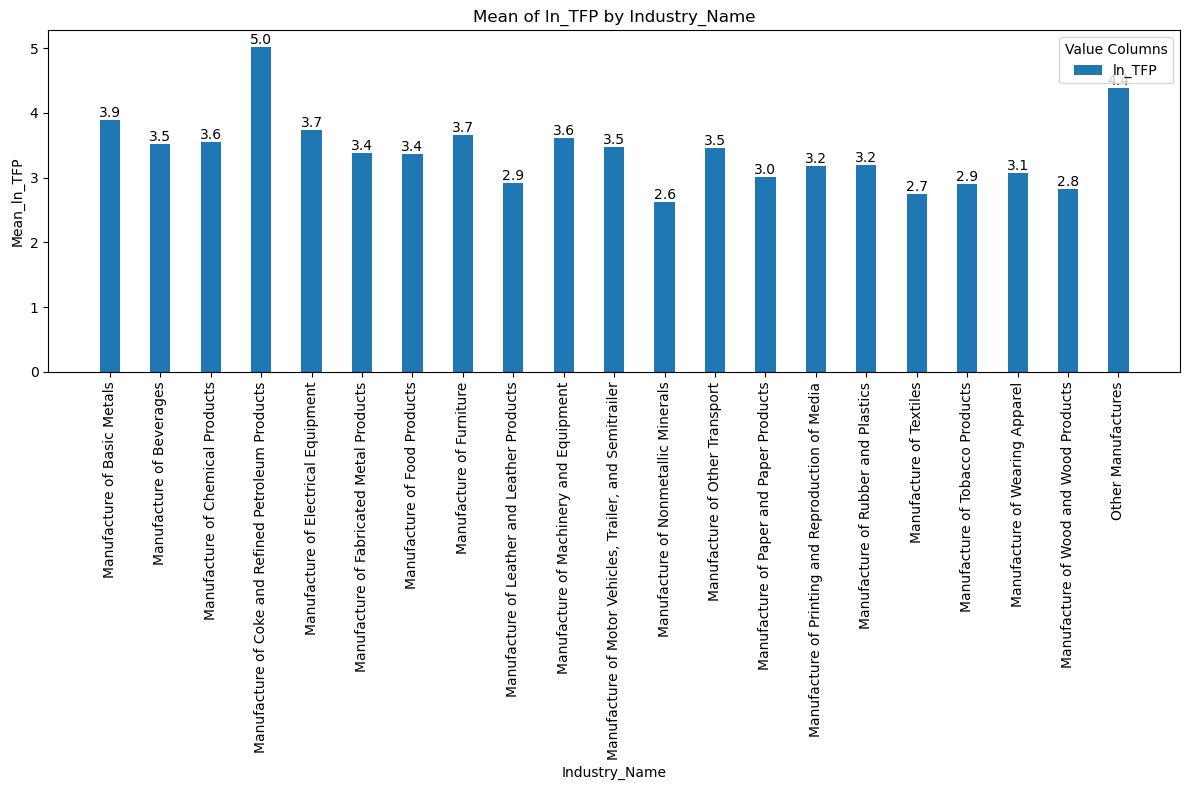

None
                                        Industry_Name  Mean_ln_TFP  Max_ln_TFP  Min_ln_TFP
0                         Manufacture of Basic Metals     3.888126    6.960305   -1.132536
1                            Manufacture of Beverages     3.525346    6.411138    0.503009
2                    Manufacture of Chemical Products     3.551442    6.713832   -5.727374
3   Manufacture of Coke and Refined Petroleum Prod...     5.022467    6.708232    2.497949
4                 Manufacture of Electrical Equipment     3.740144    6.394844   -0.225650
5            Manufacture of Fabricated Metal Products     3.386625    7.607975    0.108486
6                        Manufacture of Food Products     3.363836    7.184855   -0.153408
7                            Manufacture of Furniture     3.661532    4.148180    3.232272
8         Manufacture of Leather and Leather Products     2.922106    4.329130    0.206349
9              Manufacture of Machinery and Equipment     3.609055    5.725358   -3.5

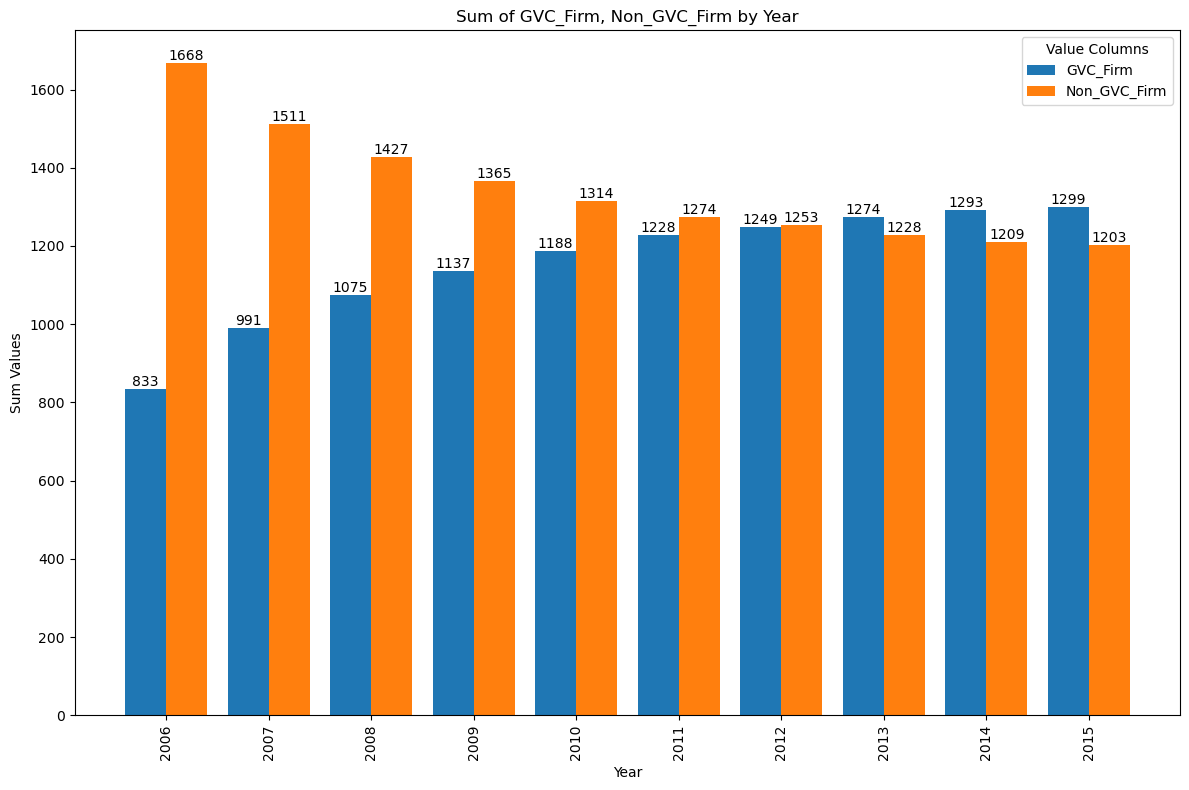

None
    Year  Non_GVC_Firm  Mean_ln_TFP
0   2006             0     3.423287
1   2006             1     3.510235
2   2007             0     3.365160
3   2007             1     3.516826
4   2008             0     3.331136
5   2008             1     3.517950
6   2009             0     3.334074
7   2009             1     3.514606
8   2010             0     3.337699
9   2010             1     3.512583
10  2011             0     3.325966
11  2011             1     3.548228
12  2012             0     3.129089
13  2012             1     3.262363
14  2013             0     3.388884
15  2013             1     3.550341
16  2014             0     3.462717
17  2014             1     3.645198
18  2015             0     3.482408
19  2015             1     3.662156


In [445]:
#Descriptive Statistics
def plot_grouped_data(data, group_by, value_columns, stats=None, plot_stat=None, 
                      decimals=0, x_label=None, y_label=None, title=None, show_data_labels=True):
    """
    Dynamically group data by one or more columns, calculate descriptive statistics for multiple value columns,
    and optionally plot the results for a specific statistic with customization options.

    Parameters:
        data (DataFrame): The dataset to analyze.
        group_by (str or list): Column(s) to group by (e.g., 'Industry_Name' or ['Industry_Name', 'GVC_Firm']).
        value_columns (str or list): Column(s) to calculate statistics for (e.g., 'ln_TFP' or ['ln_TFP', 'GVC_Firm']).
        stats (list, optional): List of statistics to calculate (default: None). If None, no table is returned.
        plot_stat (str, optional): Statistic to plot (e.g., 'mean'). If None, no plot is generated.
        decimals (int): Number of decimal places for the data labels (default: 0).
        x_label (str): Label for the x-axis (default: None).
        y_label (str): Label for the y-axis (default: None).
        title (str): Title of the chart (default: None).
        show_data_labels (bool): Whether to show data labels on the bars (default: True).

    Returns:
        DataFrame (optional): A table with grouped statistics if stats is specified.
    """
    # Ensure value_columns is a list for consistency
    value_columns = value_columns if isinstance(value_columns, list) else [value_columns]

    grouped_stats = None

    # If stats are provided, calculate them for each value_column
    if stats:
        grouped_stats = data.groupby(group_by)[value_columns].agg(stats).reset_index()

        # Flatten multi-level columns resulting from multiple value_columns and stats
        grouped_stats.columns = (
            list(group_by) +
            [f"{stat.capitalize()}_{col}" for col in value_columns for stat in stats]
        )

    # If plot_stat is provided, generate a grouped bar plot for value_columns
    if plot_stat:
        # If stats are provided, ensure plot_stat exists in the calculated stats
        if stats:
            plot_columns = [f"{plot_stat.capitalize()}_{col}" for col in value_columns]
            for plot_column in plot_columns:
                if plot_column not in grouped_stats.columns:
                    raise ValueError(f"'{plot_stat}' is not in the list of calculated stats for '{plot_column}'.")
        else:
            # If no stats are provided, compute only the necessary plot_stat
            grouped_stats = data.groupby(group_by)[value_columns].agg([plot_stat]).reset_index()
            grouped_stats.columns = (
                list(group_by) +
                [f"{plot_stat.capitalize()}_{col}" for col in value_columns]
            )

        # Combine group labels if there are multiple group_by columns
        if isinstance(group_by, list) and len(group_by) > 1:
            grouped_stats["Group"] = grouped_stats[group_by].astype(str).agg(", ".join, axis=1)
            x_labels = grouped_stats["Group"]
        else:
            x_labels = grouped_stats[group_by[0]] if isinstance(group_by, list) else grouped_stats[group_by]

        # Convert x_labels to strings to ensure they display correctly
        x_labels = x_labels.astype(str)

        # Plot grouped bar chart
        x = range(len(x_labels))  # Positions for groups
        width = 0.4  # Width of each bar
        bar_positions = [x]  # First set of positions

        # Adjust positions for multiple bars per group
        for i in range(1, len(value_columns)):
            bar_positions.append([pos + width for pos in bar_positions[-1]])

        plt.figure(figsize=(12, 8))

        # Create bars for each value_column
        for i, col in enumerate(value_columns):
            plot_column = f"{plot_stat.capitalize()}_{col}"
            bars = plt.bar(
                [pos - (width * (len(value_columns) - 1) / 2) for pos in bar_positions[i]],
                grouped_stats[plot_column],
                width=width,
                label=col
            )

            # Add data labels to each bar if enabled
            if show_data_labels:
                for bar in bars:
                    yval = bar.get_height()
                    if yval != 0:  # Avoid adding labels to zero-height bars
                        plt.text(
                            bar.get_x() + bar.get_width() / 2,  # Center the label
                            yval,  # Position the label at the top of the bar
                            f"{yval:.{decimals}f}",  # Format the label with the specified decimals
                            ha='center', va='bottom'
                        )

        # Set default x-axis label
        if not x_label:
            x_label = " | ".join(group_by) if isinstance(group_by, list) else group_by

        # Set default y-axis label
        if not y_label:
            y_label = f"{plot_stat.capitalize()}_{value_columns[0]}" if len(value_columns) == 1 else f"{plot_stat.capitalize()} Values"

        # Set default chart title
        if not title:
            title = f"{plot_stat.capitalize()} of {', '.join(value_columns)} by {' and '.join(group_by) if isinstance(group_by, list) else group_by}"

        # Add x-axis label, y-axis label, and chart title
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(title)

        # Add legend
        plt.legend(title="Value Columns")
        plt.xticks(ticks=x, labels=x_labels, rotation=90)  # Ensure proper x-axis labels
        plt.tight_layout()
        plt.show()

    # Return grouped_stats if stats were calculated
    return grouped_stats if stats else None


#No. of GVC Firms by Industry
industry_summary_ind = data_tfp.groupby(['Industry_Name']).agg(
    GVC_Firm_Count=('Company Name', lambda x: x[data_tfp['GVC_Firm'] == 1].nunique()),
    Non_GVC_Firm_Count=('Company Name', lambda x: x[data_tfp['Non_GVC_Firm'] == 1].nunique()),
    Total_Companies=('Company Name', 'nunique')
)
print(industry_summary_ind)

#No. of GVC Firms by Industry & Year
industry_summary_ind_year = data_tfp.groupby(['Industry_Name','Year']).agg(
    GVC_Firm_Count=('Company Name', lambda x: x[data_tfp['GVC_Firm'] == 1].nunique()),
    Non_GVC_Firm_Count=('Company Name', lambda x: x[data_tfp['Non_GVC_Firm'] == 1].nunique()),
    Total_Companies=('Company Name', 'nunique')
)

industry_summary_ind_year['GVC_Firm_per'] = (industry_summary_ind_year['GVC_Firm_Count'] / industry_summary_ind_year['Total_Companies']) * 100
industry_summary_ind_year['Non_GVC_Firm_per'] = (industry_summary_ind_year['Non_GVC_Firm_Count'] / industry_summary_ind_year['Total_Companies']) * 100

#Pivot the summary table
industry_summary_per = industry_summary_ind_year.pivot_table(
    index='Industry_Name',
    columns='Year',
    values=['GVC_Firm_per', 'Non_GVC_Firm_per']
)
industry_summary_per = industry_summary_per.sort_index(axis=1,level=1)
industry_summary_per.reset_index(inplace=True)
print(industry_summary_per)


#Mean TFP of industries Plot
Industry_TFP_Mean_Plot = plot_grouped_data(data_tfp, group_by=['Industry_Name'], value_columns='ln_TFP', plot_stat='mean', decimals=1)
print(Industry_TFP_Mean_Plot)
#Stats of industries Table
Industry_TFP_Stats = plot_grouped_data(data_tfp, group_by=['Industry_Name'], value_columns='ln_TFP', stats=['mean','max','min'])
print(Industry_TFP_Stats)
#Year Wise GVC and Non-GVC Firms
GVC_Firms_Count_Year = plot_grouped_data(data_tfp, group_by=['Year'], value_columns=['GVC_Firm','Non_GVC_Firm'], plot_stat='sum')
print(GVC_Firms_Count_Year)

GVC_Status = plot_grouped_data(data_tfp, group_by=['Year','Non_GVC_Firm'], value_columns=['ln_TFP'], stats=['mean'])
print(GVC_Status)

C:\Users\giris\AppData\Local\Temp\ipykernel_35816\3969871407.py:76: RuntimeWarning: invalid value encountered in scalar divide
  smd[covariate] = (mean_treated - mean_control) / np.sqrt((std_treated**2 + std_control**2) / 2)


<Figure size 1200x600 with 0 Axes>

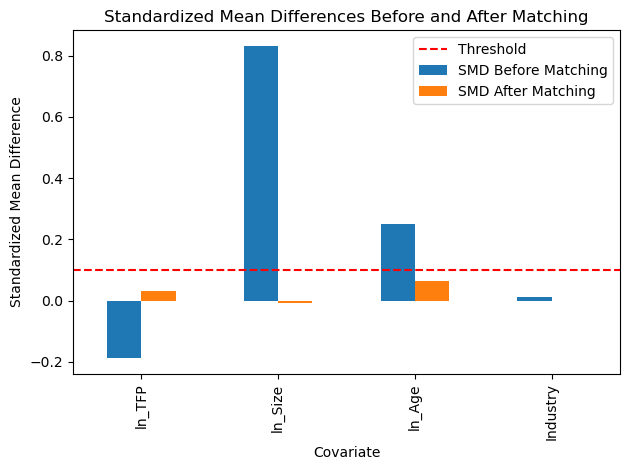

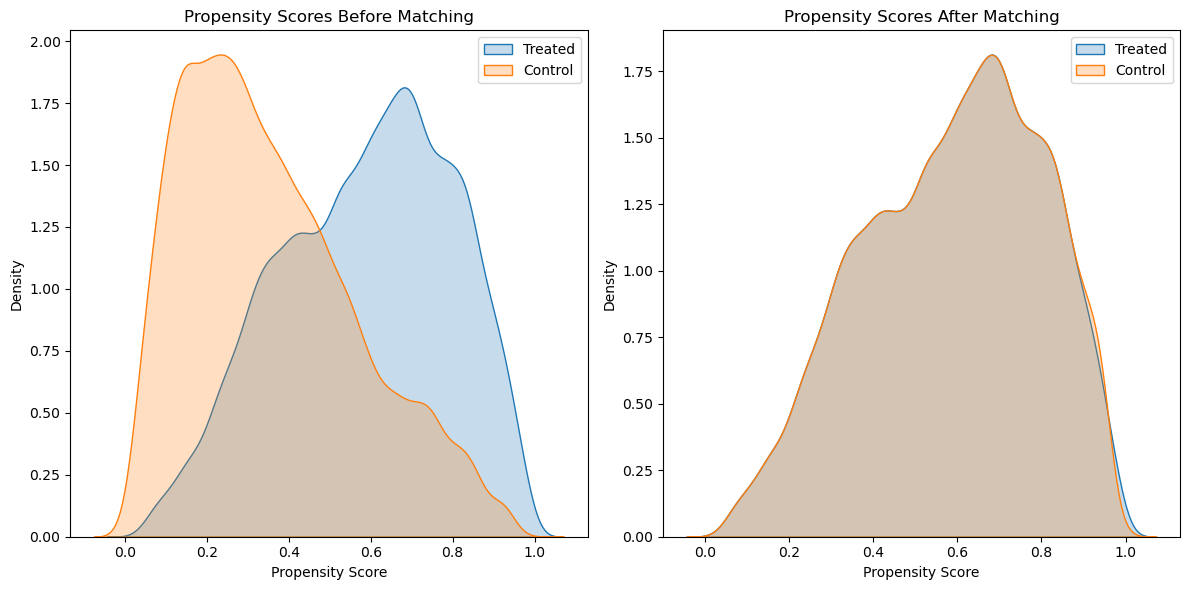

In [446]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure all columns are numeric
data_tfp[['ln_TFP', 'ln_Size', 'ln_Age']] = data_tfp[['ln_TFP', 'ln_Size', 'ln_Age']].apply(pd.to_numeric, errors='coerce')

# Assign industry dummies and drop the first dummy to avoid multicollinearity
industry_dummies = pd.get_dummies(data_tfp['Industry_Name'], prefix='Industry', drop_first=True).astype(int)
data_tfp = pd.concat([data_tfp, industry_dummies], axis=1)

# Initialize DataFrames for propensity scores and matched data if not already initialized
if 'propensity_scores' not in globals():
    propensity_scores = pd.DataFrame()

if 'matched_propensity_scores' not in globals():
    matched_propensity_scores = pd.DataFrame()

years = data_tfp['Year'].unique()  # Get unique years

for year in years:
    # Filter data for the specific year
    df_year = data_tfp[data_tfp['Year'] == year].copy()

    # Define covariates (ensure correct dummies subset)
    X = pd.concat([df_year[['ln_TFP', 'ln_Size', 'ln_Age']], df_year[industry_dummies.columns]], axis=1)
    X = sm.add_constant(X)  # Add a constant term to the model

    # Define treatment variable
    D = df_year['GVC_Firm']

    # Define outcome variable
    Y = df_year['ln_TFP']

    # Check for NaNs and non-numeric data
    if X.isna().sum().sum() > 0 or D.isna().sum() > 0 or Y.isna().sum() > 0:
        print(f"Missing values found for year {year}. Skipping...")
        continue  # Skip this year if there are NaNs

    # Estimate the logit model
    logit_model = sm.Logit(D, X).fit(method='bfgs', maxiter=1000, disp=0)

    # Calculate propensity scores
    df_year['propensity_score'] = logit_model.predict(X)

    # Store the propensity scores
    propensity_scores = pd.concat([propensity_scores, df_year[['Year', 'Company Name', 'GVC_Firm', 'propensity_score', 'ln_TFP', 'ln_Size', 'ln_Age'] + list(industry_dummies.columns)]], axis=0)
#
    # Perform k-nearest neighbor matching
    treated = df_year[df_year['GVC_Firm'] == 1]
    control = df_year[df_year['GVC_Firm'] == 0]

    nn = NearestNeighbors(n_neighbors=1)  # Use nearest neighbor matching
    nn.fit(control[['propensity_score']])

    distances, indices = nn.kneighbors(treated[['propensity_score']])
    matched_control = control.iloc[indices.flatten()]

    # Combine treated and matched control into one DataFrame
    matched_data = pd.concat([treated, matched_control])
    matched_propensity_scores = pd.concat([matched_propensity_scores, matched_data[['Year', 'Company Name', 'GVC_Firm', 'propensity_score', 'ln_TFP', 'ln_Size', 'ln_Age'] + list(industry_dummies.columns)]], axis=0)

# Balancing test: Calculate standardized mean differences (SMD) before and after matching
def calculate_smd(df, treatment_col, covariates):
    treated = df[df[treatment_col] == 1]
    control = df[df[treatment_col] == 0]
    smd = {}
    for covariate in covariates:
        mean_treated = treated[covariate].mean()
        mean_control = control[covariate].mean()
        std_treated = treated[covariate].std()
        std_control = control[covariate].std()
        smd[covariate] = (mean_treated - mean_control) / np.sqrt((std_treated**2 + std_control**2) / 2)
    return smd

covariates = ['ln_TFP', 'ln_Size', 'ln_Age'] + list(industry_dummies.columns)

# SMD before matching
smd_before = calculate_smd(propensity_scores, 'GVC_Firm', covariates)

# SMD after matching
smd_after = calculate_smd(matched_propensity_scores, 'GVC_Firm', covariates)

# Aggregate SMDs for dummy variables
def aggregate_smds(smd_dict, prefix):
    dummy_smds = {k: v for k, v in smd_dict.items() if k.startswith(prefix)}
    mean_smd = np.mean(list(dummy_smds.values()))
    return mean_smd

smd_before_agg = {cov: smd_before[cov] for cov in ['ln_TFP', 'ln_Size', 'ln_Age']}
smd_before_agg['Industry'] = aggregate_smds(smd_before, 'Industry')

smd_after_agg = {cov: smd_after[cov] for cov in ['ln_TFP', 'ln_Size', 'ln_Age']}
smd_after_agg['Industry'] = aggregate_smds(smd_after, 'Industry')

# Convert aggregated SMDs to DataFrame for plotting
smd_df = pd.DataFrame({
    'Covariate': list(smd_before_agg.keys()),
    'SMD Before Matching': list(smd_before_agg.values()),
    'SMD After Matching': list(smd_after_agg.values())
})

# Plot aggregated SMDs before and after matching
plt.figure(figsize=(12, 6))
smd_df.plot(x='Covariate', y=['SMD Before Matching', 'SMD After Matching'], kind='bar')
plt.axhline(0.1, color='r', linestyle='--', label='Threshold')
plt.title('Standardized Mean Differences Before and After Matching')
plt.xlabel('Covariate')
plt.ylabel('Standardized Mean Difference')
plt.legend()
plt.tight_layout()
plt.show()

# Plot density plots for propensity scores before and after matching
plt.figure(figsize=(12, 6))

# Before matching
plt.subplot(1, 2, 1)
sns.kdeplot(data=propensity_scores[propensity_scores['GVC_Firm'] == 1]['propensity_score'], label='Treated', fill=True)
sns.kdeplot(data=propensity_scores[propensity_scores['GVC_Firm'] == 0]['propensity_score'], label='Control', fill=True)
plt.title('Propensity Scores Before Matching')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()

# After matching
plt.subplot(1, 2, 2)
sns.kdeplot(data=matched_propensity_scores[matched_propensity_scores['GVC_Firm'] == 1]['propensity_score'], label='Treated', fill=True)
sns.kdeplot(data=matched_propensity_scores[matched_propensity_scores['GVC_Firm'] == 0]['propensity_score'], label='Control', fill=True)
plt.title('Propensity Scores After Matching')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()


In [447]:
#CHecking VIF

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Check VIF
X = pd.concat([data_tfp[['ln_TFP', 'ln_Size', 'ln_Age']], industry_dummies], axis=1)
X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)


                                             Variable        VIF
0                                               const  54.166368
1                                              ln_TFP   1.278376
2                                             ln_Size   1.068260
3                                              ln_Age   1.057473
4                   Industry_Manufacture of Beverages   1.218909
5           Industry_Manufacture of Chemical Products   1.759467
6   Industry_Manufacture of Coke and Refined Petro...   1.094674
7        Industry_Manufacture of Electrical Equipment   1.378190
8   Industry_Manufacture of Fabricated Metal Products   1.312433
9               Industry_Manufacture of Food Products   1.574991
10                  Industry_Manufacture of Furniture   1.008230
11  Industry_Manufacture of Leather and Leather Pr...   1.076524
12    Industry_Manufacture of Machinery and Equipment   1.526903
13  Industry_Manufacture of Motor Vehicles, Traile...   1.605678
14       Industry_Manufac